In [1]:
!pip show tensorflow

Name: tensorflow
Version: 2.16.2
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /opt/homebrew/lib/python3.10/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: tensorflow-macos


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models


/Users/sagarpoudel/Desktop/captcha1/xenv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
class Config:
    # Data parameters
    DATA_DIR = Path('captcha_images_v2')
    IMG_WIDTH = 200
    IMG_HEIGHT = 50
    BATCH_SIZE = 32
    TRAIN_SIZE = 0.9

    # Model parameters
    CONV_FILTERS = [32, 64, 128]
    KERNEL_SIZE = (3, 3)
    POOL_SIZE = (2, 2)
    LSTM_UNITS = [128, 64]
    DROPOUT_RATE = 0.25

    # Training parameters
    EPOCHS = 100
    EARLY_STOPPING_PATIENCE = 10
    INITIAL_LEARNING_RATE = 0.001




In [3]:
config = Config()

In [4]:
def setup_dataset():
    """Download and extract the CAPTCHA dataset."""
    if not config.DATA_DIR.exists():
        !curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
        !unzip captcha_images_v2.zip
        !rm captcha_images_v2.zip

In [5]:
def load_data():
    """Load image paths and labels, create character mappings."""
    images = sorted(list(map(str, list(config.DATA_DIR.glob("*.png")))))
    labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
    characters = set(char for label in labels for char in label)

    print(f"Number of images found: {len(images)}")
    print(f"Number of unique characters: {len(characters)}")
    print(f"Characters present: {characters}")

    return images, labels, characters

In [6]:
def create_char_mappings(characters):
    """Create character-to-number and number-to-character mappings."""
    char_to_num = layers.StringLookup(vocabulary=list(characters), mask_token=None)
    num_to_char = layers.StringLookup(
        vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
    )
    return char_to_num, num_to_char

In [7]:
def split_data(images, labels, train_size=0.9, shuffle=True):
    """Split data into training and validation sets."""
    size = len(images)
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)

    train_samples = int(size * train_size)
    x_train = np.array(images)[indices[:train_samples]]
    x_valid = np.array(images)[indices[train_samples:]]
    y_train = np.array(labels)[indices[:train_samples]]
    y_valid = np.array(labels)[indices[train_samples:]]

    return x_train, x_valid, y_train, y_valid

In [8]:

def encode_single_sample(img_path, label):
    """Encode a single sample for model input."""
    # Load and preprocess image
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [config.IMG_HEIGHT, config.IMG_WIDTH])

    # Data augmentation (only for training)
    if tf.random.uniform([]) > 0.5:
        img = tf.image.random_brightness(img, 0.2)
    if tf.random.uniform([]) > 0.5:
        img = tf.image.random_contrast(img, 0.8, 1.2)

    # Encode label
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))

    return {"image": img, "label": label}


In [9]:

def prepare_dataset(x, y, is_training=True):
    """Prepare dataset for training or validation."""
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    if is_training:
        dataset = dataset.shuffle(buffer_size=len(x))

    dataset = (
        dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(config.BATCH_SIZE)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )
    return dataset


In [10]:

def visualize_data(dataset):
    """Visualize a batch of images with their labels."""
    plt.figure(figsize=(10, 5))
    for batch in dataset.take(1):
        images = batch["image"]
        labels = batch["label"]

        for i in range(16):
            ax = plt.subplot(4, 4, i + 1)
            img = (images[i] * 255).numpy().astype("uint8")
            label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")

            plt.imshow(img[:, :, 0], cmap="gray")
            plt.title(label, fontsize=8)
            plt.axis("off")

    plt.tight_layout()
    plt.show()


In [11]:

class CTCLayer(layers.Layer):
    """Custom CTC layer for loss calculation."""
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred


In [12]:

def build_model():
    """Build the CAPTCHA recognition model."""
    # Input layers
    input_img = layers.Input(shape=(config.IMG_HEIGHT, config.IMG_WIDTH, 1),
                           name="image", dtype="float32")
    labels = layers.Input(name="label", shape=(None,), dtype="int64")

    # CNN layers
    x = input_img
    for filters in config.CONV_FILTERS:
        x = layers.Conv2D(filters, config.KERNEL_SIZE,
                         activation="relu",
                         padding="same",
                         kernel_initializer="he_normal")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D(config.POOL_SIZE)(x)

    # Reshape for RNN
    new_shape = ((config.IMG_WIDTH // 8), (config.IMG_HEIGHT // 8) * config.CONV_FILTERS[-1])
    x = layers.Reshape(target_shape=new_shape)(x)

    # RNN layers
    for units in config.LSTM_UNITS:
        x = layers.Bidirectional(
            layers.LSTM(units, return_sequences=True, dropout=config.DROPOUT_RATE)
        )(x)

    # Output layer
    x = layers.Dense(len(char_to_num.get_vocabulary()) + 1, activation="softmax")(x)
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Create model
    model = models.Model(inputs=[input_img, labels], outputs=output, name="captcha_model")

    # Compile model
    optimizer = keras.optimizers.Adam(learning_rate=keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=config.INITIAL_LEARNING_RATE,
        decay_steps=1000,
        decay_rate=0.9
    ))
    model.compile(optimizer=optimizer)

    return model


In [13]:

def decode_predictions(pred):
    """Decode model predictions to text."""
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred,
                                     input_length=input_len,
                                     greedy=True)[0][0]

    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


In [14]:
def create_prediction_model(model):
    """Create a prediction model without the CTC layer."""
    return keras.models.Model(
        model.get_layer(name="image").input,
        model.get_layers()[-2].output
    )


<h1> Call

In [15]:
setup_dataset()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 8863k  100 8863k    0     0  2681k      0  0:00:03  0:00:03 --:--:-- 6718k
Archive:  captcha_images_v2.zip
   creating: captcha_images_v2/
 extracting: captcha_images_v2/ydd3g.png  
 extracting: captcha_images_v2/36nx4.png  
 extracting: captcha_images_v2/3bnyf.png  
 extracting: captcha_images_v2/8y6b3.png  
 extracting: captcha_images_v2/268g2.png  
 extracting: captcha_images_v2/mnef5.png  
 extracting: captcha_images_v2/5p8fm.png  
 extracting: captcha_images_v2/bxxfc.png  
 extracting: captcha_images_v2/8ypdn.png  
 extracting: captcha_images_v2/gpxng.png  
 extracting: captcha_images_v2/e4gd7.png  
 extracting: captcha_images_v2/pbpgc.png  
 extracting: captcha_images_v2/m4g8g.png  
  inflating: captcha_images_v2/c43b4.png  
 extracting: captc

In [16]:
images, labels, characters = load_data()


Number of images found: 1040
Number of unique characters: 19
Characters present: {'w', 'g', 'e', 'y', 'm', 'c', '4', '7', '3', 'p', 'd', '6', 'f', '2', 'x', 'n', '8', 'b', '5'}


In [17]:
char_to_num, num_to_char = create_char_mappings(characters)


In [18]:
x_train, x_valid, y_train, y_valid = split_data(images, labels, config.TRAIN_SIZE)


In [19]:
train_dataset = prepare_dataset(x_train, y_train, is_training=True)
validation_dataset = prepare_dataset(x_valid, y_valid, is_training=False)

2024-11-10 22:10:35.984373: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


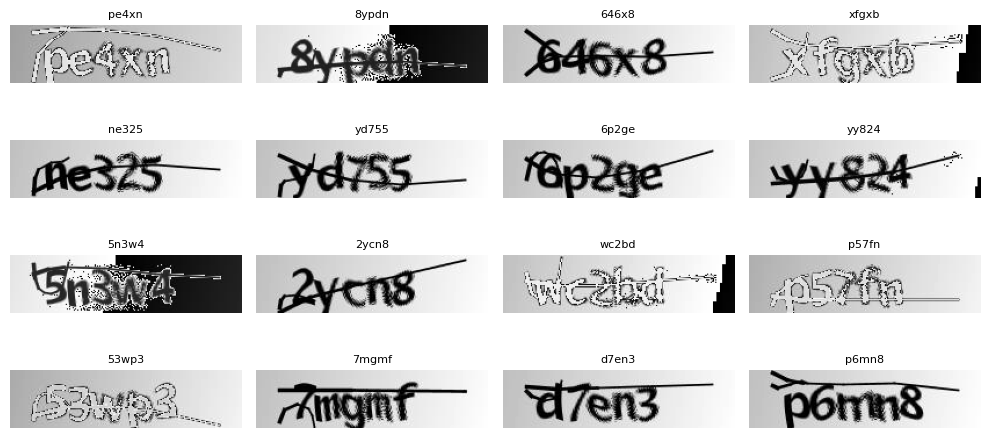

In [20]:
visualize_data(train_dataset)

In [21]:
model = build_model()

In [22]:
model.summary()

Model: "captcha_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 50, 200,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 50, 200,   │        320 │ image[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 50, 200,   │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 25, 100,   │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 25, 100,   │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 100,   │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 12, 50,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 12, 50,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 50,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 6, 25,     │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 25, 768)   │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 25, 256)   │    918,528 │ reshape[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 25, 128)   │    164,352 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 25, 21)    │      2,709 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 25, 21)    │          0 │ label[0][0],      │
│                     │                   │            │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,179,157 (4.50 MB)

 Trainable params: 1,178,709 (4.50 MB)

 Non-trainable params: 448 (1.75 KB)

In [23]:
# Create callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras",  # Changed from .h5 to .keras
        monitor="val_loss",
        save_best_only=True
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=config.EARLY_STOPPING_PATIENCE,
        restore_best_weights=True
    ),
    keras.callbacks.TensorBoard(log_dir="logs")
]


In [24]:
# Train model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=config.EPOCHS,
    callbacks=callbacks
)

Epoch 1/100


/Users/sagarpoudel/Desktop/captcha1/xenv/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['image', 'label']. Received: the structure of inputs={'image': '*', 'label': '*'}
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 275ms/step - loss: 786.1348 - val_loss: 489.4357
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 312ms/step - loss: 522.2318 - val_loss: 488.6307
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 259ms/step - loss: 520.6154 - val_loss: 496.9283
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 338ms/step - loss: 518.8513 - val_loss: 549.6203
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 324ms/step - loss: 516.2414 - val_loss: 628.9693
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 316ms/step - loss: 513.4162 - val_loss: 603.5496
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 262ms/step - loss: 504.6328 - val_loss: 488.3598
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 287ms/step - loss: 483.3047 - val_loss: 492.4214
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 290ms/step - loss: 449.9886 - val_loss: 471.7918
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 268ms/step - loss: 416.2173 - val_loss: 442.1247
Epoch 11/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 273ms/step - loss: 381.4530 - val_loss: 422.9415
Epoch 

Prediction

In [28]:
def create_prediction_model(model):
    """Create a prediction model without the CTC layer."""
    # Ensure the correct layers are accessed for the model's input and output
    return keras.models.Model(
        inputs=model.input,  # Directly use the model's input
        outputs=model.layers[-2].output  # Use the second-to-last layer's output (before CTC layer)
    )

In [29]:
prediction_model = create_prediction_model(model)

In [31]:
for batch in validation_dataset.take(1):
    # Get prediction from model
    prediction = prediction_model.predict(batch["image"])

    # Decode predictions (make sure your decode_predictions function works correctly)
    pred_texts = decode_predictions(prediction)

    # Iterate over the first few predictions
    for i in range(min(5, len(pred_texts))):
        print(f"Predicted: {pred_texts[i]}")

        # Ensure the label is decoded correctly (use tf.strings.reduce_join to handle tensors)
        true_label = tf.strings.reduce_join(num_to_char(batch["label"][i])).numpy().decode("utf-8")
        print(f"True: {true_label}\n")


ValueError: Layer "functional_1" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'data:0' shape=(32, 50, 200, 1) dtype=float32>]

In [34]:
def create_prediction_model_without_label(model):
    """Create a prediction model without the CTC layer, and using only the image input."""
    return keras.models.Model(
        inputs=model.input[0],  # Use only the image input
        outputs=model.layers[-2].output  # Output before CTC layer (last RNN layer)
    )

prediction_model = create_prediction_model_without_label(model)


In [35]:
for batch in validation_dataset.take(1):
    # Pass only the image for prediction
    prediction = prediction_model.predict(batch["image"])
    
    # Decode predictions (make sure your decode_predictions function works correctly)
    pred_texts = decode_predictions(prediction)

    for i in range(min(5, len(pred_texts))):
        print(f"Predicted: {pred_texts[i]}")
        true_label = tf.strings.reduce_join(num_to_char(batch["label"][i])).numpy().decode("utf-8")
        print(f"True: {true_label}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
Predicted: gxxcn[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]
True: exycn

Predicted: 7mmpn[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]
True: 7wnpm

Predicted: nbn5e[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]
True: nbp3e

Predicted: cn23[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]
True: een23

Predicted: n48n[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]
True: nm46n



2024-11-10 22:23:21.568547: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
